# CNN for Training RADIOML 2018 Dataset

In [1]:
import json
import os
import pickle as pkl
from random import seed

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, MaxPool2D
from tensorflow.keras.layers import GlobalAveragePooling2D, AveragePooling2D, Add, Input, Flatten

## Import Preprocessed Data

In [2]:
def import_data(classes, start_label, path=None):
    ''' Function imports preprocessed data and labels
    
    Args:
        classes: ordered list of classes
        start_label: starting index from list of classes
        path: path for input files
        
    Returns:
        Dataset and labels for inputting into tensorflow model
    
    '''
    data = []
    labels = []
    
    if path == None:
        path = '../Data/RFML_Data/RS_1024/'
        width = 1024
        ext = '_1024_'
    
    elif path == 1:
        path = '../Data/RFML_Data/RS_128/'
        width = 128
        ext = '_128_'
    
    for cls in classes:
        temp_D_path = path + cls + ext + 'D.npy'
        temp_L_path = path + cls + ext + 'L.npy'
        
        d = np.load(temp_D_path)
        l = np.load(temp_L_path)
        
        l = np.delete(l, slice(start_label + len(classes), 24), 1) # Remove trailing zeros
        if start_label != 0:
            l = np.delete(l,slice(0, start_label),1)               # Remove leading zeros
            
        data.append(d)
        labels.append(l)

    data = np.reshape(data, (len(classes) * 106496, 2, width, 1))
    labels = np.reshape(labels, (len(classes) * 106496, len(classes)))

    return data, labels

### Collect full Preprocessed Dataset

In [3]:
classes = ['32PSK',
            '16APSK',
            '32QAM',
            'FM',
            'GMSK',
            '32APSK',
            'OQPSK',
            '8ASK',
            'BPSK',
            '8PSK',
            'AM-SSB-SC',
            '4ASK',
            '16PSK',
            '64APSK',
            '128QAM',
            '128APSK',
            'AM-DSB-SC',
            'AM-SSB-WC',
            '64QAM',
            'QPSK',
            '256QAM',
            'AM-DSB-WC',
            'OOK',
            '16QAM']

# Class index to start training from
start_label = 0

# Number of classes
labels = 5

X, y = import_data(classes[start_label:start_label+labels], start_label, path=None)

print("Classes Training on: ",classes[start_label:start_label+labels])
print('Input Shape: ',X.shape, '\t', 'Output Shape: ', y.shape)

Classes Training on:  ['32PSK', '16APSK', '32QAM', 'FM', 'GMSK']
Input Shape:  (532480, 2, 1024, 1) 	 Output Shape:  (532480, 5)


### Test Dataset 2 with Minimum SNR

In [4]:
filename = '../Data/2018.01/GOLD_XYZ_OSC.0001_1024.hdf5'
data = h5py.File(filename, 'r')
start_leng = start_label*106496
leng = 106496*labels
Z = data['Z'][start_leng:start_leng+leng]

min_snr = 0

# Parse data for minimum snr range
X_2 = np.array(list(map(lambda x: X[x], np.where(Z >= min_snr)[0])))
y_2 = np.array(list(map(lambda x: y[x], np.where(Z >= min_snr)[0])))

print('Input Shape: ',X_2.shape, '\t', 'Output Shape: ', y_2.shape)

Input Shape:  (327680, 2, 1024, 1) 	 Output Shape:  (327680, 5)


## Develop and Train Model

In [5]:
def cnn2d(input_dim, labels):
    ''' Function develops 2D CNN model
    
    Args:
        input_dim: Dimensions of input data (2, X, 1)
        labels: int for number of target labels
        
    Returns:
        Model for training

    '''    
    x_input = Input(shape=input_dim)
        
    x = Conv2D(64, kernel_size = (2,15), padding='same')(x_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPool2D(pool_size=(2,2), padding='same')(x)
    
    x = Conv2D(64, kernel_size = (1,7), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPool2D(pool_size=(1,2), padding='same')(x)
    
    x = Conv2D(32, kernel_size = (1,5), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPool2D(pool_size=(1,2), padding='same')(x)
    
    x = Conv2D(32, kernel_size = (1,3), padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    x = Flatten()(x)

    output = Dense(labels, activation='softmax')(x)
    
    model = tf.keras.models.Model(x_input, output)
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    return model

In [6]:
def train_mod(model, x_train, y_train, x_test=None, y_test=None, epochs=10):
    ''' Function fits and trains model
    
    Args:
        model: Compiled model to be trained
        x_train: input data for training
        y_train: target data for training
        x_test: input data for testing
        y_test: target data for testing
        epochs: epochs for training
        
    Returns:
        Tensorflow data containing training results

    '''
    
    if all(v is None for v in [x_test, y_test]):
        data = model.fit(x_train, y_train, epochs=epochs)
        
    else:
        data = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=epochs)
    
    return data

In [7]:
seed(14)
# Set for training all SNR values
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.25)

# Set for training selected SNR range
x_train_2, x_val_2, y_train_2, y_val_2 = train_test_split(X_2, y_2, test_size=0.25)

In [8]:
model = cnn2d((2, x_train.shape[-2], 1), labels)

[print(i.shape, i.dtype) for i in model.inputs]
[print(o.shape, o.dtype) for o in model.outputs]
model.summary()

(None, 2, 1024, 1) <dtype: 'float32'>
(None, 5) <dtype: 'float32'>
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2, 1024, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 2, 1024, 64)       1984      
_________________________________________________________________
batch_normalization (BatchNo (None, 2, 1024, 64)       256       
_________________________________________________________________
activation (Activation)      (None, 2, 1024, 64)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 1, 512, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 512, 64)        28736     
____________________________________________________________

In [9]:
# Train the model for 5 classes where SNR > 0
data = train_mod(model, x_train_2, y_train_2, x_val_2, y_val_2, 3)

Epoch 1/3
7680/7680 [==============================] - 357s 46ms/step - loss: 0.1719 - accuracy: 0.9262 - val_loss: 0.1092 - val_accuracy: 0.9552
Epoch 2/3
7680/7680 [==============================] - 355s 46ms/step - loss: 0.0697 - accuracy: 0.9715 - val_loss: 0.0544 - val_accuracy: 0.9773
Epoch 3/3
7680/7680 [==============================] - 356s 46ms/step - loss: 0.0523 - accuracy: 0.9779 - val_loss: 0.0391 - val_accuracy: 0.9838


### Evaluate Results

In [10]:
def plot_results(*args):
    ''' Function plots results from model training
    
    Args:
        args: output data from model.fit funtion and label for legend
        
    Returns:
        None
        
    '''
    colors = ['b', 'g', 'r', 'c', 'm', 'y']
    labels = []
    labels.append(args[int(len(args)/2):])
    
    fig, axs = plt.subplots(2,1, figsize=(16,12))
    i = 0
    for results in args[:int(len(args)/2)]:
        loss = results.history.get('loss')
        acc = results.history.get('accuracy')
        val_loss = results.history.get('val_loss')
        val_acc = results.history.get('val_accuracy')

        plt.sca(axs[0])
        plt.plot(range(1, len(loss)+1), loss, linestyle='dashed', color=colors[i],
                 label=f'{labels[0][i]} Training Loss')
        plt.plot(range(1, len(val_loss)+1), val_loss, color=colors[i],
                 label=f'{labels[0][i]} Validation Loss')

        if i == int(len(args)/2) - 1:
            plt.xlim([1, len(loss)])
            plt.xticks(range(1,len(loss)+1))
            plt.grid()
            plt.legend()
            axs[0].set_xlabel('Epochs')
            axs[0].set_ylabel('Loss')

        plt.sca(axs[1])
        plt.plot(range(1,len(acc)+1), acc, linestyle='dashed', color=colors[i],
                 label = f'{labels[0][i]} Training Accuracy')
        plt.plot(range(1,len(val_acc)+1), val_acc, color=colors[i],
                 label=f'{labels[0][i]} Validation Accuracy')
        
        if i == int(len(args)/2) - 1:
            plt.xlim([1, len(acc)])
            plt.xticks(range(1,len(acc)+1))
            plt.grid()
            plt.legend()
            axs[1].set_xlabel('Epochs')
            axs[1].set_ylabel('Accuracy')
        
        i+=1
    
    plt.show()
    
    return None

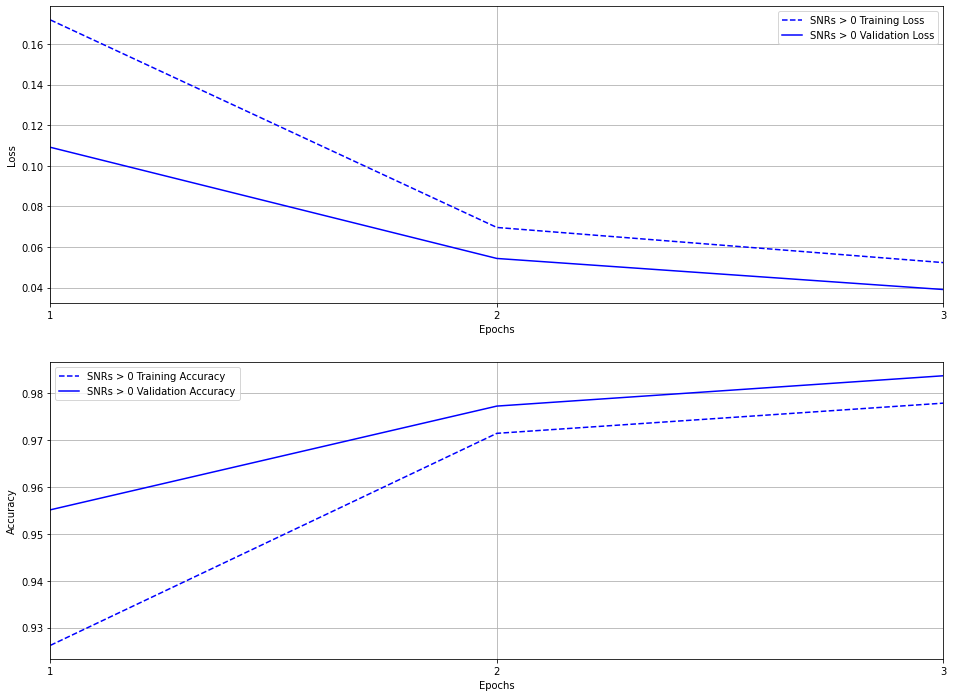

In [11]:
plot_results(data, "SNRs > 0")

## Comparison of Many SNR Ranges

In [12]:
def load_save_results(data=None, min_snr=None, filename="Training_Results_V1.json"):
    ''' Function saves results from model training into dict
    
    Args:
        data: output data from model.fit funtion
        min_snr: minimum snr for the trained range
        filename: filename for saving dict into
        
    Returns:
        Loaded results
        
    '''
    
    if data == None:
        return pkl.load(open(filename, "rb"))
    
    else:
        d = pkl.load(open(filename, "rb"))
        d[min_snr] = data.history
        with open(filename, 'wb') as file_pi:
            pkl.dump(d, file_pi)
        
        return d

In [13]:
saved_data = load_save_results()

In [14]:
def comparison_plot(dic):
    ''' Function plots results from model training for different SNR ranges
    
    Args:
        dic: output data from model.fit funtion stored in dict
        
    Returns:
        None
        
    '''
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k',(0.3,0.6,0.7), (0.2,0.8,0.2), (.8, 0.2, 0.2)]
    fig, axs = plt.subplots(2,1, figsize=(10,15))
    
    i = 0
    
    for key in sorted(dic.keys()):
        loss = dic[key].get('loss')
        acc = dic[key].get('accuracy')
        val_loss = dic[key].get('val_loss')
        val_acc = dic[key].get('val_accuracy')

        plt.sca(axs[0])
        plt.plot(range(1, len(loss)+1), loss, linestyle='dashed', color=colors[i],
                 label=f'{str(key)}:30 SNR Training Loss')
        plt.plot(range(1, len(val_loss)+1), val_loss, color=colors[i],
                 label=f'{str(key)}:30 SNR Validation Loss')
        
        if i == len(dic.keys()) - 1:
            plt.xlim([1, len(loss)])
            plt.xticks(range(1,len(acc)+1))
            plt.yticks(np.arange(0.8, 0, -0.04))
            plt.grid()
            plt.legend()
            plt.legend(bbox_to_anchor=(1.0, 1.0), loc="upper left")
            axs[0].set_xlabel('Epochs')
            axs[0].set_ylabel('Loss')

        plt.sca(axs[1])
        plt.plot(range(1,len(acc)+1), acc, linestyle='dashed', color=colors[i],
                 label = f'{str(key)}:30 SNR Training Accuracy')
        plt.plot(range(1,len(val_acc)+1), val_acc, color=colors[i],
                 label=f'{str(key)}:30 SNR Validation Accuracy')
        
        if i == len(dic.keys()) - 1:
            plt.xlim([1, len(acc)])
            plt.xticks(range(1,len(acc)+1))
            plt.yticks(np.arange(0.65, 1, 0.025))
            plt.grid()
            plt.legend(bbox_to_anchor=(1.0, 1.0), loc="upper left")
            axs[1].set_xlabel('Epochs')
            axs[1].set_ylabel('Accuracy')

        
        i+=1
    
    plt.show()
    return None

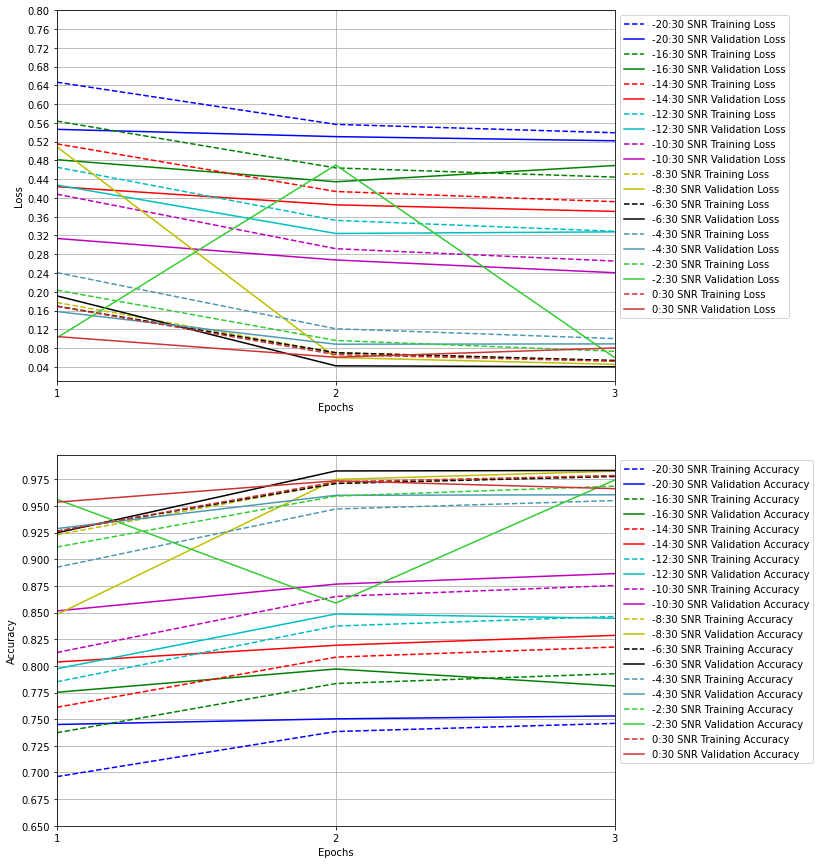

In [15]:
comparison_plot(saved_data)

In [16]:
tf.keras.backend.clear_session()